In [1]:
# import libraries
import numpy as np
import pandas as pd

# seaborn is for making plots
import seaborn as sns
import matplotlib.pyplot as plt
import regex
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# These are all the imports needed for the assignment
%matplotlib inline

#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [2]:
columns = ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']

- "C:/Users/19495/Downloads/amazon_reviews_us_Toys_v1_00.tsv.gz"

- names = columns because this allows is to focus on only the attributes we care about

- sep = '\t' since this is a tsv file, this informs program to separate based on tabs, not commas

- check that on_bad_lines arg is not removing valid things!

- **take out first line! because there is a restatement of the column names so string**

In [3]:
# initializing empty dataframes for testing and training data
training_data = pd.DataFrame()
testing_data = pd.DataFrame()
# on_bad_lines = 'skip' does not seem to work
one_file = pd.read_csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Electronics_v1_00.tsv.gz", names =  columns, sep = '\t').iloc[1:,:]

In [4]:
one_file.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
1,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
2,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
3,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
4,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
5,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [5]:
one_file.shape

(3091103, 15)

In [6]:
one_file.isnull().sum().sort_values(ascending = False)

review_body          88
review_headline      31
review_date          24
product_title         4
verified_purchase     0
vine                  0
total_votes           0
helpful_votes         0
star_rating           0
product_category      0
product_parent        0
product_id            0
review_id             0
customer_id           0
marketplace           0
dtype: int64

In [7]:
one_file.dropna(inplace=True)
one_file.isnull().sum().sort_values(ascending = False)

review_date          0
review_body          0
review_headline      0
verified_purchase    0
vine                 0
total_votes          0
helpful_votes        0
star_rating          0
product_category     0
product_title        0
product_parent       0
product_id           0
review_id            0
customer_id          0
marketplace          0
dtype: int64

In [8]:
#convert all mixed datatypes --> string objects (unable to convert to int)
one_file['customer_id'] = one_file['customer_id'].apply(int) #1
one_file['product_parent'] = one_file['product_parent'].apply(int) #4
one_file['star_rating'] = one_file['star_rating'].apply(int) #7
one_file['helpful_votes'] = one_file['helpful_votes'].apply(int) #8
one_file['total_votes'] = one_file['total_votes'].apply(int) #9

In [9]:
one_file['star_rating'].value_counts()

5    1779347
4     536400
1     357802
3     238382
2     179025
Name: star_rating, dtype: int64

General Notes
- to remove certain column values, run smthg like one_file[one_file["star_rating"] != 3]

In [10]:
# df w/ ratings of 3 removed for sentiment analysis
rem_file = one_file[one_file['star_rating'] != 3]
# if rating greater than 3 --> 1, if lower --> 0
rem_file['positively_rated'] = np.where(rem_file['star_rating'] > 3, 1, 0)

In [11]:
rem_file['positively_rated'].value_counts()

1    2315747
0     536827
Name: positively_rated, dtype: int64

In [12]:
rem_file.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,positively_rated
1,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31,1
2,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31,1
3,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31,1
4,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31,0
5,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31,1


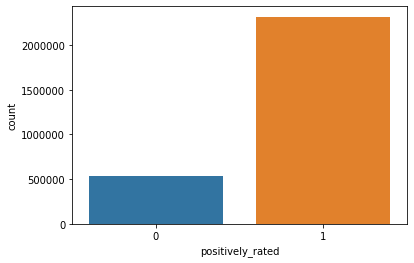

In [13]:
sns.countplot(rem_file['positively_rated'])

- 'review_body' is the independent variable, while 'positively_rated' is the dependent variable

In [14]:
x_train, x_test, y_train, y_test = train_test_split(rem_file['review_body'], rem_file['positively_rated'], 
                                                    random_state = 50)

In [15]:
print(x_train)

1539775    Flimsy construction and poor sound range vs so...
2504431    Product did not work. I hooked up both ends. O...
3070343    I purchased both the ZHDTV and the ...RCA ampl...
1250047    UPDATE!!!<br />The team at Mpow really stand b...
1905213    No complaints; these are perfect!  I wish they...
                                 ...                        
2747483    This may be the most rugged CD/DVD storage pos...
729500     It works great. I was having problems getting ...
2526170    This shelving unit was easy to put together an...
1241297                       Great product at a great price
2139970    Searched the net for several weeks before deci...
Name: review_body, Length: 2139430, dtype: object


- the .get_feature_names() will give us the # of diff terms! Features w/ low tf-idf scores are either very common across all reviews or rarely used. High tf-idf features are highly used in specific reviews, but rarely used in all docs

In [16]:
vect = TfidfVectorizer().fit(x_train)
len(vect.get_feature_names())

308301

In [17]:
x_train_vectorized = vect.transform(x_train)

In [18]:
# This is model fitting. Once it's done, we can make predictions
model = LogisticRegression()
model.fit(x_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
predictions = model.predict(vect.transform(x_test))
print(predictions)

[1 0 1 ... 1 1 1]


In [20]:
# Compute AUC score
print("AUC:", roc_auc_score(y_test, predictions))

AUC: 0.8844488688126042


In [21]:
# Look at which sentiments have the smallest and largest tf-idf score
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

- The Smallest Coef words either appear across all reviews, or only really in long reviews
- The Largest Coef words appear frequently in a review but did not appear commonly across all reviews

In [22]:
print("Smallest Coef", feature_names[sorted_coef_index[:10]])

Smallest Coef ['not' 'unacceptable' 'poor' 'worst' 'useless' 'returning' 'terrible'
 'disappointing' 'worthless' 'stopped']


In [23]:
print("Largest Coef", feature_names[sorted_coef_index[:-11:-1]])

Largest Coef ['great' 'love' 'perfect' 'excellent' 'perfectly' 'amazing' 'awesome'
 'highly' 'best' 'easy']


## Attempting Neutral Feature

In [29]:
# Try cleaning on sample of df
sample_df = one_file.sample(n = 500000)
sample_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
1995733,US,40829271,R3FDIB59DW24F5,B004MMEI2I,947426659,Panasonic RP-HJC120 Earbuds w/iPhone controller,Electronics,1,0,2,N,Y,These headphones suck.,I used these MAYBE 10 times before the right s...,2013-05-03
2324892,US,34582759,RTK2I545IUHP7,B003XM9774,508552334,HDMI-High-Speed,Electronics,5,0,0,N,Y,"Top quality, full-featured affordable HDMI cable","I'm very satisfied with this HDMI cable, it wo...",2012-08-23
1685817,US,45113514,RCVADQTBWEPXC,B004NQU4YY,773939861,Sony CDP-CE500 5-Disc CD Changer (Black),Electronics,4,2,2,N,Y,Trouble With USB Playback Can Be Avoided,I've had my unit a little over one month and h...,2013-12-10
470477,US,51838514,R2VRZ05B9HGMWX,B00GK7ZF0W,942327613,Picasso 4 x Blu-Ray 25GB 25 Disk Pack,Electronics,5,0,0,N,Y,Five Stars,Great service. Great product.,2015-04-02
2408254,US,52057803,R2CZDT4F0NHF4K,B006WHPQSG,44209786,Philips SHL5605PP/28 CitiScape Downtown Headph...,Electronics,4,0,0,Y,N,Very good sound if you want to spend the money,"Let me first say that for me, these are pricey...",2012-03-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055746,US,31474076,R2EXL38XJBIIAT,B0000AQIFV,161773413,Rio Fuse 128 MB MP3 Player,Electronics,1,1,1,N,N,juggle - stick will malfunction,The juggle will break after few mounths (bough...,2004-08-07
2301185,US,24573000,R2VNDYFV37OLMZ,B000IJY8DS,654766735,"High Speed HDMI Cable Supports Ethernet, 3D an...",Electronics,1,2,3,N,Y,"Useless, stay away from this cable",I purchased this item 3 months ago and after 2...,2012-10-01
408657,US,38963338,R1T8HSBVGDRPBB,B00A0JUO1Q,741960790,X-Mini MAX XAM15-GM Portable Capsule Speaker S...,Electronics,5,0,0,N,N,Fabulous!,Fabulous and perfect for my needs to use with ...,2015-04-22
1032721,US,43582787,RVXR1JR5I5LCI,B00DC8IEE6,405952636,"Filter, MoCA ""POE"" Filter for Cable TV Coaxial...",Electronics,5,0,0,N,N,Five Stars,As described.,2014-10-16


In [68]:
# Better data cleaning
br_removed = sample_df['review_body'].apply(lambda review: review.replace('<br /><br />', " "))
quote_removed = sample_df['review_body'].apply(lambda review: review.replace('&#34', ""))
# removing quotes produces smthg like this --> 'The product has great ;sound; --> we must remove punctuation

# we're trying to predict whether sentiment is neg or pos based on the feature words we picked up in the training data
# based on the level of positive/negetive/neutral percentage of a review, can we predict whether a review is verified/not?

In [69]:
# will try sentiment analysis and prediction with neutral factor
# if rating greater than 3 --> 1, if lower --> 0
sent_df = one_file.copy()
#sent_df['positively_rated'] = np.where(one_file['star_rating'] > 3, 'G', 'B')
pos_rating = sent_df['star_rating'].apply(lambda rate: 'G' if (rate > 3) else ('N' if (rate==3) else 'B'))
sent_df = sent_df.assign(positively_rated = pos_rating)

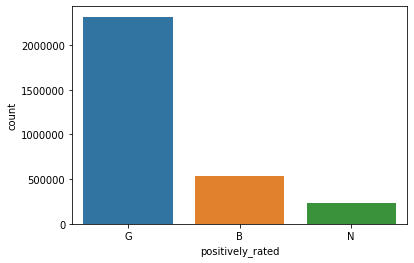

In [71]:
sns.countplot(sent_df['positively_rated'])

In [72]:
x_train, x_test, y_train, y_test = train_test_split(sent_df['review_body'], sent_df['positively_rated'], random_state = 50)

In [73]:
vect = TfidfVectorizer().fit(x_train)

In [ ]:
x_train_vectorized = vect.transform(x_train)
#model = LogisticRegression()
#model.fit(x_train_vectorized, y_train)

In [78]:
# since linear regression only works for binary dependent variable, try naive bayes or random forest?
# is predicting with bigrams more accurate than unigrams?
# do we HAVE to remove punctutation and stop words when cleaning data?
# what if we used the max percentage to use linear regression to try and predict verified or non-verified?
# OR use multiple features and use KNN

## PySpark

In [24]:
! pip install pyspark

In [25]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [26]:
electronics = spark.read.csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Electronics_v1_00.tsv.gz", sep = '\t')#.iloc[1:,:]
electronics.show(vertical=True)
toys = spark.read.csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Toys_v1_00.tsv.gz")

-RECORD 0--------------------
 _c0  | marketplace          
 _c1  | customer_id          
 _c2  | review_id            
 _c3  | product_id           
 _c4  | product_parent       
 _c5  | product_title        
 _c6  | product_category     
 _c7  | star_rating          
 _c8  | helpful_votes        
 _c9  | total_votes          
 _c10 | vine                 
 _c11 | verified_purchase    
 _c12 | review_headline      
 _c13 | review_body          
 _c14 | review_date          
-RECORD 1--------------------
 _c0  | US                   
 _c1  | 41409413             
 _c2  | R2MTG1GCZLR2DK       
 _c3  | B00428R89M           
 _c4  | 112201306            
 _c5  | yoomall 5M Antenn... 
 _c6  | Electronics          
 _c7  | 5                    
 _c8  | 0                    
 _c9  | 0                    
 _c10 | N                    
 _c11 | Y                    
 _c12 | Five Stars           
 _c13 | As described.        
 _c14 | 2015-08-31           
-RECORD 2--------------------
 _c0  | US

In [27]:
electronics.filter(electronics.marketplace.isNotNull()).show()

AttributeError: 'DataFrame' object has no attribute 'marketplace'

## Dask

In [ ]:
import dask as d
import dask.dataframe as dd
import dask.array as da

In [ ]:
electronics_dask = dd.read_csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Electronics_v1_00.tsv.gz", sep ='\t')